In [1]:

file1_path = '\\titanic\\train.csv'
file2_path = '\\test.csv'
file3_path = '\\titanic\\target_variable.csv'


In [2]:
#libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from sklearn.utils import shuffle

# Surviving the Titanic

## Glossary

*EDA is completed prior to data cleaning to prevent data leakage*

1. **Introduction**
        a. Problem
        b. Method and Objective
        c. Data

2. **Exploratory Data Analysis**

3. **Feature Engineering**

4. **Data Cleaning**
        a. Imbalance in the target variable
        a. Handling Missing Values
        b. One-Hot Encoding
        c. Prepare Test Data
        d. Handling mismatching shape sizes

5. **Modeling**
        a. Parameter Tuining - Random Forest
        b. Parameter Tuining - AdaBoost
        c. Parameter Tuining - Support Vector Machine
6. **Results and Analysis**
        a. Using Cross-Validation as a Final Measure of Performance
7. **Conclusion**


## Introduction

In tackling the classic classification problem of predicting survival on the Titanic, the objective is straightforward: train a model using actual Titanic data to predict who would have lived and who would have perished. Despite the problem's apparent simplicity, there are challenges such as missing values in the dataset and necessary feature engineering to achieve a reasonable accuracy score.

For these reasons, I was intrigued by the problem. Despite the problem being popular, there are many different approaches that can be taken. With this being my first data set of which I plan to model using a supervised learning algorithim, I wanted to start with a problem that I could understand well. This data set offers this for me, I have a basic knowledge of the Titanic which gives me some domain knowledge to leverage and many of the features are intuitive. I offer this information in an effort to be transparent, if you look up this data set you will see many solutions people have taken. I took my own approach using the techniques learned in this course to arrive at my final model. 

### Problem
Attempt to predict survival on the Titanic using a supervised learning algorithim.

### Method and Objective
The objective of this report is to define a model that predicts survival aboard the Titanic. The method to achieve this will be to complete EDA, Feature Engineering, cleaning and finally modeling utilizing the supervised learning algorithims: Random Forest, AdaBoost and Support Vector Machine and evaluation measures to arrive at the best one.

### Data

Kaggle. (2012). Titanic: Machine Learning from Disaster. Kaggle. https://www.kaggle.com/c/titanic/data

The compeition pre splits the data but I chose to combine this to make one data set and complete the split myself. 

Below are the descriptions for the target value, "Survival" and the predictors. Data types read in can be found in EDA. 

| Column   | Description                    | Notes                                       |
|----------|--------------------------------|---------------------------------------------|
| survival | Survival                       | 0 = No, 1 = Yes                             |
| pclass   | Ticket class                   | 1 = 1st, 2 = 2nd, 3 = 3rd                   |
| sex      | Sex                            | M/F                                            |
| Age      | Age in years                   |                                             |
| sibsp    | # of siblings / spouses aboard |                                             |
| parch    | # of parents / children aboard |                                             |
| ticket   | Ticket number                  |                                             |
| fare     | Passenger fare                 |                                             |
| cabin    | Cabin number                   |                                             |
| embarked | Port of Embarkation            | C = Cherbourg, Q = Queenstown, S = Southampton |


In [3]:
# Read in the files, randomize the rows and split 75/25

# Read CSV files into pandas DataFrames
train = pd.read_csv(file1_path)
gender_submission = pd.read_csv(file3_path)
test = pd.read_csv(file2_path)

# Merge test and gender_submission on 'PassengerId'
merged_test = pd.merge(test, gender_submission, on='PassengerId')

# Merge train with the merged test on 'PassengerId'
merged_df = pd.concat([train, merged_test], ignore_index=True)

# Shuffle the DataFrame
shuffled_df = shuffle(merged_df, random_state=95)

# Perform an 75/25 train-test split
train, test = train_test_split(shuffled_df, test_size=0.25, random_state=95)


In [4]:
#See the shape of the data sets
print('The shape of the data frame when combined is', shuffled_df.shape)
print('The shape of the training data set is', train.shape)
print('The shape of the testing data set is', test.shape)

The shape of the data frame when combined is (1309, 12)
The shape of the training data set is (981, 12)
The shape of the testing data set is (328, 12)


##  Exploratory Data Analysis

To start, Summary Statistics, Data types and Missing values are output first. This allows the user to immediatley see null values as well as potential outliers or other anamolies that needed to be investigated. 

In [5]:
# Summary statistics of the training data
print("\nSummary Statistics of Train Data:")
print(train.describe())

# Data types and missing values
print("\nData Types and Missing Values in Train Data:")
print(train.info())



Summary Statistics of Train Data:
       PassengerId    Survived      Pclass         Age       SibSp  \
count   981.000000  981.000000  981.000000  785.000000  981.000000   
mean    672.482161    0.377166    2.283384   30.112739    0.494393   
std     374.230469    0.484924    0.842263   14.505117    1.013792   
min       2.000000    0.000000    1.000000    0.170000    0.000000   
25%     359.000000    0.000000    1.000000   21.000000    0.000000   
50%     677.000000    0.000000    3.000000   28.000000    0.000000   
75%     993.000000    1.000000    3.000000   39.000000    1.000000   
max    1308.000000    1.000000    3.000000   76.000000    8.000000   

            Parch        Fare  
count  981.000000  981.000000  
mean     0.404689   34.233775  
std      0.913805   53.065480  
min      0.000000    0.000000  
25%      0.000000    7.895800  
50%      0.000000   14.500000  
75%      0.000000   31.387500  
max      9.000000  512.329200  

Data Types and Missing Values in Train Data:


Outliers are not immediately obvious in the above, it looks like there are some null values in Age and Cabin columns. 

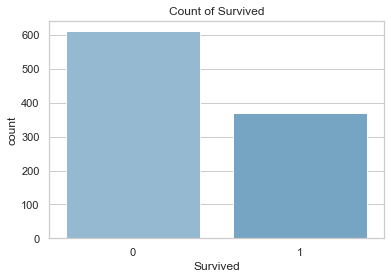

<Figure size 864x288 with 0 Axes>

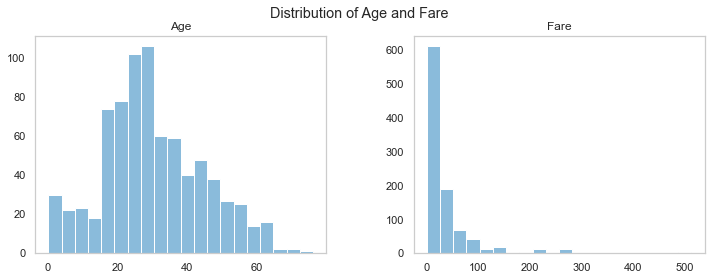

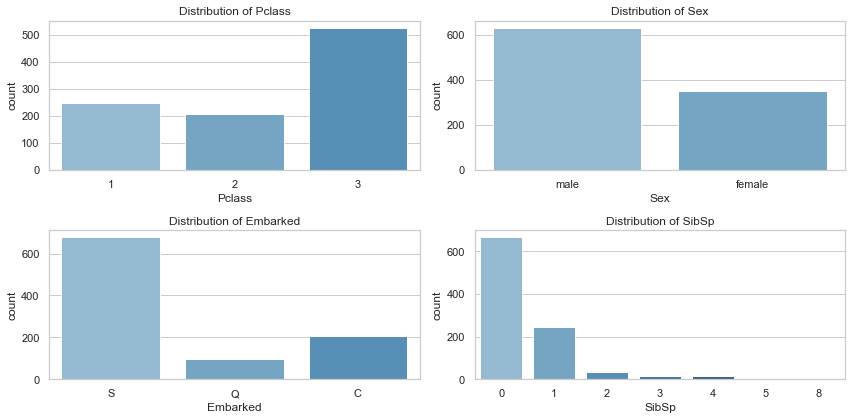

In [6]:
# Set the style for seaborn and choose a color palette
sns.set(style="whitegrid")
blue_palette = sns.color_palette("Blues_d")
sns.set_palette(blue_palette)

# 1. Distribution of Survived
plt.figure(figsize=(6, 4))
sns.countplot(x='Survived', data=train)
plt.title('Count of Survived')
plt.show()

# 2. Distribution of Age and Fare
plt.figure(figsize=(12, 4))
train[['Age', 'Fare']].hist(figsize=(12, 4), bins=20, grid=False, alpha=1)
plt.suptitle('Distribution of Age and Fare')
plt.show()

# 3. Distribution of Categorical Features
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
sns.countplot(x='Pclass', data=train)
plt.title('Distribution of Pclass')

plt.subplot(2, 2, 2)
sns.countplot(x='Sex', data=train)
plt.title('Distribution of Sex')

plt.subplot(2, 2, 3)
sns.countplot(x='Embarked', data=train)
plt.title('Distribution of Embarked')

# Explicitly set the color palette for 'SibSp' count plot
plt.subplot(2, 2, 4)
sns.countplot(x='SibSp', data=train, palette=blue_palette)
plt.title('Distribution of SibSp')

plt.tight_layout()
plt.show()


Immediatley, it is seen there are more instances of death than survival in the dataset. This is something that will be investigated further during data cleaning as it suggests imbalance.

The distribution of age seems to follow a normal distribution, while the fare exhibits a non-parametric and apparently skewed distribution. This distribution aligns with the expectation that the majority of tickets would be base fare, catering to the working class, as the Titanic was designed to be accessible to people from various economic backgrounds. This is corroborated by a significant portion of passengers falling under class '3', the lowest passenger class.

Additionally, the dataset reflects a higher number of male passengers than females, and a substantial proportion of passengers are traveling without a sibling or spouse.

Below, box plots are utilized to visualize the outliers. While it becomes more obvious through this visualization that there are outliers present, none are not reasonable. The highest ticket sold was estimated to be 512 euros which is represented in the dataset. Additionall no age represented is not reasonable either. As a result, it is not acceptable to omit them from the data set. 

(https://www.cruisemummy.co.uk/titanic-ticket-prices/#:~:text=The%20most%20expensive%20ticket%20purchased,Cardeza%2C%20an%20American%20arts%20patron)

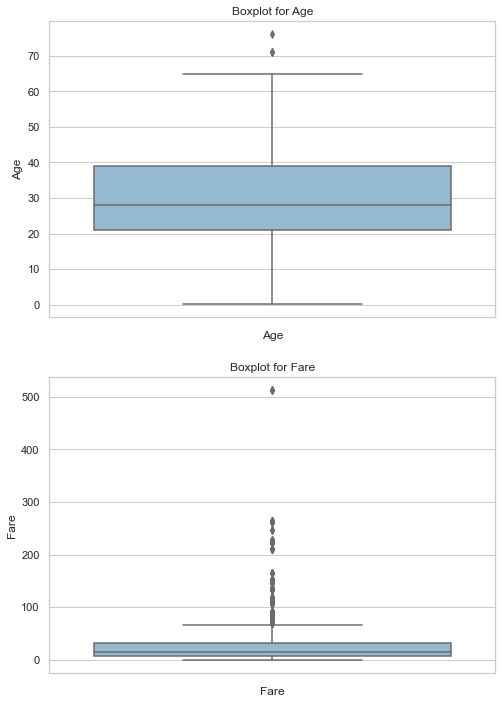

In [7]:
# Set the style for seaborn and choose a color palette
sns.set(style="whitegrid")
blue_palette = sns.color_palette("Blues_d")
sns.set_palette(blue_palette)

# Create a figure with two subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 12))

# Boxplot for 'Age'
sns.boxplot(y='Age', data=train, ax=axes[0])
axes[0].set_title('Boxplot for Age')
axes[0].set_xlabel('Age')

# Boxplot for 'Fare'
sns.boxplot(y='Fare', data=train, ax=axes[1])
axes[1].set_title('Boxplot for Fare')
axes[1].set_xlabel('Fare')

# Save the boxplots with the same colors and transparency
plt.show()


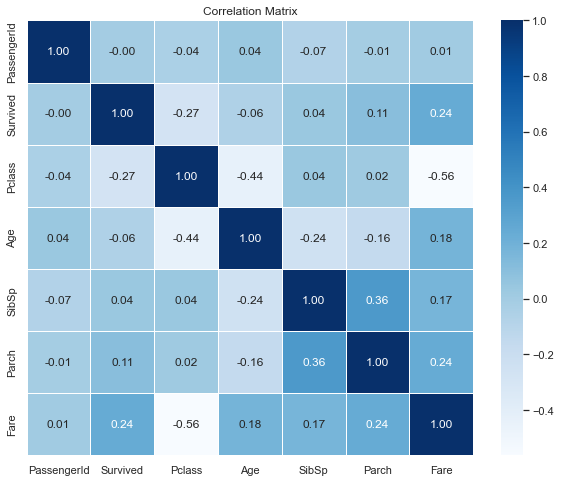

In [8]:
# Set the style for seaborn and choose a color palette
sns.set(style="whitegrid")
blue_palette = sns.color_palette("Blues_d")
sns.set_palette(blue_palette)

# Create correlation matrix and display the top 5 correlations
correlation_matrix = train.corr()

# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')

# Save the correlation matrix heatmap as a transparent image
plt.show()


Next, a correlation matrix was created to visualize the potential correlations within the data set. Immediatley we see Pclass and Age; Fare and Survived appear to be correlated. 

# Feature Engineering

Feature Engineering is necessary to extract features from Raw Data. Some of the below were results of my own interests but others are necessary for modeling. For example, I was interested in seeing if the title of someone suggested they may have survived as well as if they were alone or not. Intuitively, someone with a title other then Mr., Mrs., or Ms. might be of higher class and possibly had a higher chance of living. Additionally, if someone was alone they could have acted more selfishly in their own survival not feeling the need to sacrafice themselves for one of their loved ones lives. 

In [9]:
import warnings
warnings.filterwarnings('ignore')

# 'Title' in name
train['n_title'] = train["Name"].str.extract(' ([A-Za-z]+)\.', expand=False)

# Family size
train["n_family_size"] = train["SibSp"] + train["Parch"] + 1

# Is alone
train.loc[((train['SibSp'] + train['Parch']) > 0), "n_is_alone"] = "No"
train.loc[((train['SibSp'] + train['Parch']) == 0), "n_is_alone"] = "Yes"

# Age level
train.loc[(train['Age'] < 18), 'n_age_cat'] = 'Young'
train.loc[(train['Age'] >= 18) & (train['Age'] < 56), 'n_age_cat'] = 'Mature'
train.loc[(train['Age'] >= 56), 'n_age_cat'] = 'Senior'

# Sex according to age
train.loc[(train['Sex'] == 'male') & (train['Age'] <= 21), 'n_sex_cat'] = 'Young Male'
train.loc[(train['Sex'] == 'male') & (train['Age'] > 21) & (train['Age'] < 50), 'n_sex_cat'] = 'Mature Male'
train.loc[(train['Sex'] == 'male') & (train['Age'] >= 50), 'n_sex_cat'] = 'Senior Male'
train.loc[(train['Sex'] == 'female') & (train['Age'] <= 21), 'n_sex_cat'] = 'Young Female'
train.loc[(train['Sex'] == 'female') & (train['Age'] > 21) & (train['Age'] < 50), 'n_sex_cat'] = 'Mature Female'
train.loc[(train['Sex'] == 'female') & (train['Age'] >= 50), 'n_sex_cat'] = 'Senior Female'

print("-" * 33)
print("New Shape of Dataset:")
print("-" * 33)
print(train.shape)
print("-" * 33)
train.head()


---------------------------------
New Shape of Dataset:
---------------------------------
(981, 17)
---------------------------------


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,n_title,n_family_size,n_is_alone,n_age_cat,n_sex_cat
1185,1186,0,3,"Wittevrongel, Mr. Camille",male,36.0,0,0,345771,9.5000,NaN,S,Mr,1,Yes,Mature,Mature Male
480,481,0,3,"Goodwin, Master. Harold Victor",male,9.0,5,2,CA 2144,46.9000,NaN,S,Master,8,No,Young,Young Male
264,265,0,3,"Henry, Miss. Delia",female,NaN,0,0,382649,7.7500,NaN,Q,Miss,1,Yes,NaN,NaN
485,486,0,3,"Lefebre, Miss. Jeannie",female,NaN,3,1,4133,25.4667,NaN,S,Miss,5,No,NaN,NaN
954,955,1,3,"Bradley, Miss. Bridget Delia",female,22.0,0,0,334914,7.7250,NaN,Q,Miss,1,Yes,Mature,Mature Female


In [10]:
# Summary statistics of the training data
print("\nSummary Statistics of Train Data:")
print(train.describe())

# Data types and missing values
print("\nData Types and Missing Values in Train Data:")
print(train.info())


Summary Statistics of Train Data:
       PassengerId    Survived      Pclass         Age       SibSp  \
count   981.000000  981.000000  981.000000  785.000000  981.000000   
mean    672.482161    0.377166    2.283384   30.112739    0.494393   
std     374.230469    0.484924    0.842263   14.505117    1.013792   
min       2.000000    0.000000    1.000000    0.170000    0.000000   
25%     359.000000    0.000000    1.000000   21.000000    0.000000   
50%     677.000000    0.000000    3.000000   28.000000    0.000000   
75%     993.000000    1.000000    3.000000   39.000000    1.000000   
max    1308.000000    1.000000    3.000000   76.000000    8.000000   

            Parch        Fare  n_family_size  
count  981.000000  981.000000     981.000000  
mean     0.404689   34.233775       1.899083  
std      0.913805   53.065480       1.590472  
min      0.000000    0.000000       1.000000  
25%      0.000000    7.895800       1.000000  
50%      0.000000   14.500000       1.000000  
75%  

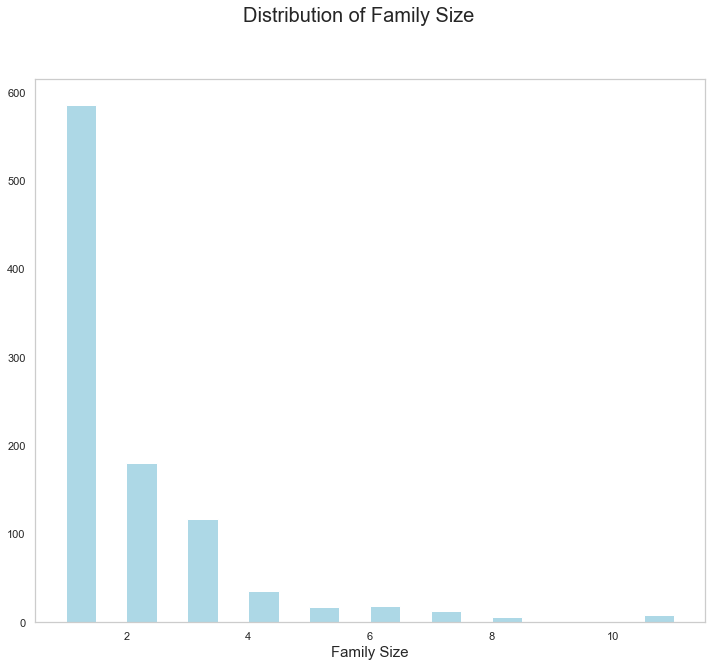

<Figure size 864x720 with 0 Axes>

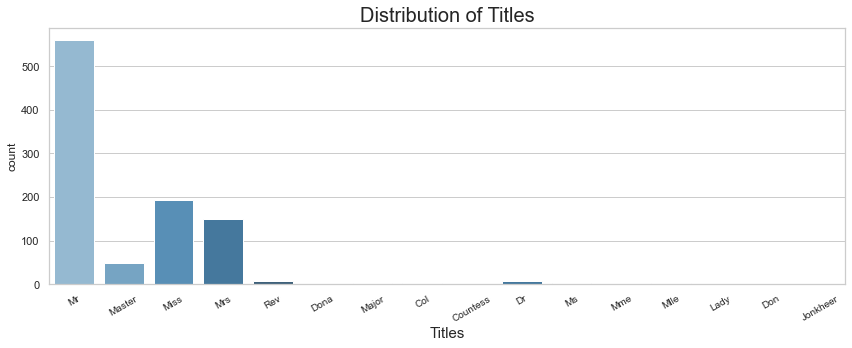

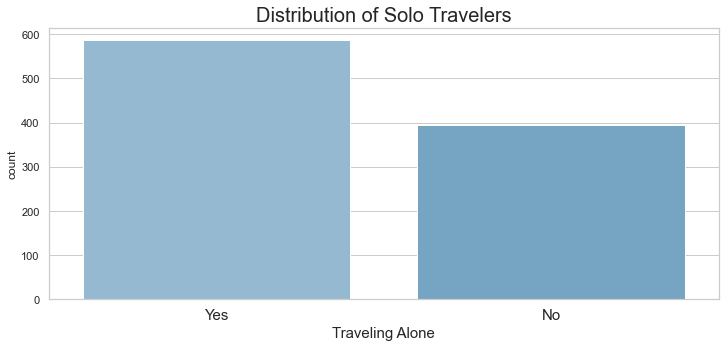

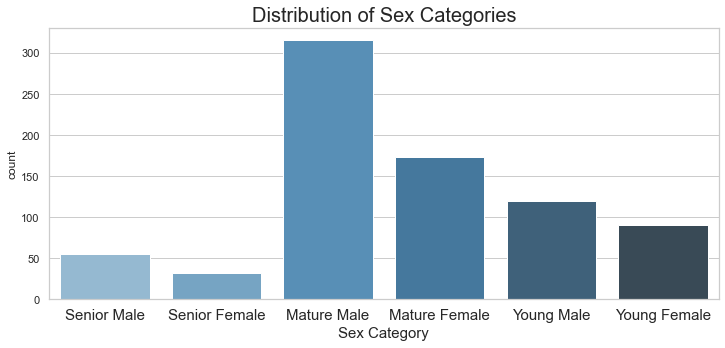

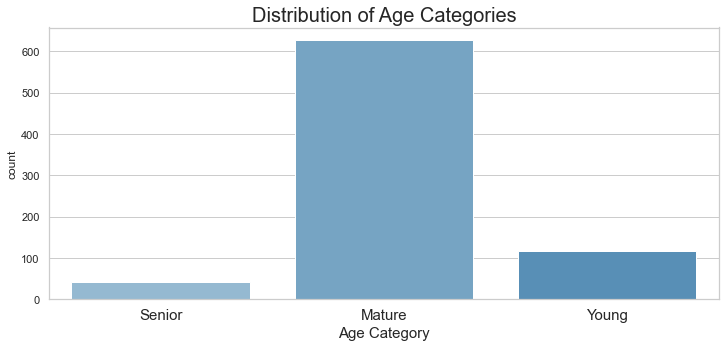

In [11]:
# Set the style for seaborn and choose a color palette
sns.set(style="whitegrid")
blue_palette = sns.color_palette("Blues_d")
sns.set_palette(blue_palette)

# Visualizing the distribution of numerical features
plt.figure(figsize=(12, 10))
train["n_family_size"].hist(bins=20, grid=False, color='lightblue')
plt.suptitle('Distribution of Family Size', fontsize=20)  # Larger suptitle font
plt.xlabel('Family Size', fontsize=15)
plt.show()

# Visualizing the distribution of categorical features
plt.figure(figsize=(12, 10))

# Distribution of Titles
plt.figure(figsize=(12, 5))
sns.countplot(x = 'n_title', data = train, palette=blue_palette)
plt.title('Distribution of Titles', fontsize=20)
plt.xlabel('Titles', fontsize=15)
plt.xticks(rotation=30, fontsize=10)
plt.tight_layout()  # Add this line to adjust layout
plt.show()

# Distribution of solo travelers
plt.figure(figsize=(12, 5))
sns.countplot(x='n_is_alone', data=train, palette=blue_palette)
plt.title('Distribution of Solo Travelers', fontsize=20)
plt.xlabel('Traveling Alone', fontsize=15)
plt.xticks(fontsize=15)
plt.show()

# Distribution of sex categories
age_order = ['Senior Male', 'Senior Female', 'Mature Male', 'Mature Female', 'Young Male', 'Young Female']
plt.figure(figsize=(12, 5))
sns.countplot(x='n_sex_cat', data=train, order=age_order, palette=blue_palette)
plt.title('Distribution of Sex Categories', fontsize=20)
plt.xlabel('Sex Category', fontsize=15)
plt.xticks(fontsize=15)
plt.show()

# Distribution of age categories
age_order = ['Senior', 'Mature', 'Young']
plt.figure(figsize=(12, 5))
sns.countplot(x='n_age_cat', data=train, order=age_order, palette=blue_palette)
plt.title('Distribution of Age Categories', fontsize=20)
plt.xlabel('Age Category', fontsize=15)
plt.xticks(fontsize=15)
plt.show()


In [12]:
# Create correlation matrix and display the top 10 correlations 
correlation_matrix_FE = train.corr()

In [13]:
#See the top 10 correlations because the plot is unreadable
# Flatten the upper triangle of the correlation matrix, excluding the diagonal
upper_triangle = correlation_matrix_FE.where(np.triu(np.ones(correlation_matrix_FE.shape), k=1).astype(bool))

# Stack the values, sort them, and get the top and bottom 10 correlations
top_positive_corr = upper_triangle.stack().sort_values(ascending=False).head(10)
top_negative_corr = upper_triangle.stack().sort_values(ascending=True).head(10)

# Display the results
print("Top 5 Positive Correlations:")
print(top_positive_corr)

print("\nTop 5 Negative Correlations:")
print(top_negative_corr)

Top 5 Positive Correlations:
SibSp     n_family_size    0.844183
Parch     n_family_size    0.803941
SibSp     Parch            0.359878
Fare      n_family_size    0.250154
Parch     Fare             0.242336
Survived  Fare             0.239778
Age       Fare             0.179909
SibSp     Fare             0.174016
Survived  Parch            0.106537
          n_family_size    0.083801
dtype: float64

Top 5 Negative Correlations:
Pclass       Fare            -0.563862
             Age             -0.436198
Survived     Pclass          -0.271950
Age          n_family_size   -0.247803
             SibSp           -0.243912
             Parch           -0.164033
PassengerId  SibSp           -0.072414
Survived     Age             -0.062301
PassengerId  n_family_size   -0.053536
             Pclass          -0.041033
dtype: float64


Some insights gained; many people were traveling alone, much of the distribution is spread between mature men and mature women and the titles, while unique, are likely not contributors to whether someone survived or not as there are very few that are not Mr or Miss. 

The correlation matrix with the featured engineered columns included does little to lend insight except that Survived and Sex_Female appear to be closely correlated. This makes sense as Women and Childeren were priortized for life rafts. 

## Data Cleaning

### Imbalance in the target variable

In [14]:
imbalance_ratio = train['Survived'].value_counts()[0] / train['Survived'].value_counts()[1]
print(f'Imbalance Ratio: {imbalance_ratio}')

Imbalance Ratio: 1.6513513513513514


This is not an exteme imbalance. However, the algoritihms used can be sensitive to imbalance so I have opted to balance the target variable in a new data set. This data set will be the what trains all the models.

In [15]:
# Identify minority class (Survived = 1)
minority_class = 1

# Split dataset
majority_class_data = train[train['Survived'] == 0]
minority_class_data = train[train['Survived'] == 1]

# Apply bootstrapping to the minority class
bootstrapped_minority_class = minority_class_data.sample(n=len(majority_class_data), replace=True, random_state=42)

# Combine datasets
balanced_train = pd.concat([majority_class_data, bootstrapped_minority_class])

# Shuffle data
balanced_train = balanced_train.sample(frac=1, random_state=42)


In [16]:
imbalance_ratio = balanced_train['Survived'].value_counts()[0] / balanced_train['Survived'].value_counts()[1]
print(f'Imbalance Ratio: {imbalance_ratio}')

Imbalance Ratio: 1.0


This worked well and now we have a more balanced training set to use.

### Handling Missing Values

Next, addressing missing values became crucial. The 'Cabin' column contained numerous missing values, and unfortunately, finding a reasonable way to impute them proved challenging. Assigning cabins based on class and fare would require an accurate ship map, which wasn't available. Consequently, I decided to remove the 'Cabin' column entirely. 

However, for the 'Age' column, estimation was possible. I calculated the median age for each passenger class (1, 2, 3) since the correlation matrix indicated a relationship between these two predictors. Subsequently, I filled in the missing values in the 'Age' column with the respective median age based on the passenger's class.

In [17]:
# See null values
train.isna().sum()

PassengerId        0
Survived           0
Pclass             0
Name               0
Sex                0
Age              196
SibSp              0
Parch              0
Ticket             0
Fare               0
Cabin            755
Embarked           2
n_title            0
n_family_size      0
n_is_alone         0
n_age_cat        196
n_sex_cat        196
dtype: int64

In [18]:
# Balanced Dataset
# Remove "Cabin"
balanced_train = balanced_train.drop('Cabin', axis=1)

# Remove 'Ticket', 'PassengerID', and 'Name' columns
columns_to_drop = ['Ticket', 'PassengerId', 'Name']
balanced_train = balanced_train.drop(columns=columns_to_drop)

# Drop the rows where 'Embarked' and 'Fare' are NA
balanced_train = balanced_train.dropna(subset=['Embarked'])
balanced_train = balanced_train.dropna(subset=['Fare'])


In [19]:
# Calculate the median age for each passenger class
median_age_by_class_balanced = balanced_train.groupby('Pclass')['Age'].median()

# Fill missing values in 'Age' column based on passenger class
balanced_train['Age'] = balanced_train.apply(
    lambda row: median_age_by_class_balanced[row['Pclass']] if pd.isnull(row['Age']) else row['Age'],
    axis=1
)


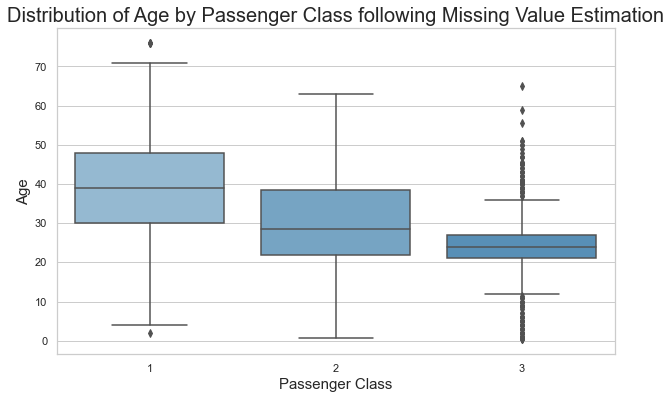

In [20]:
# Set the style for seaborn and choose a color palette
sns.set(style="whitegrid")
blue_palette = sns.color_palette("Blues_d")
sns.set_palette(blue_palette)

# Create a boxplot for the distribution of age by passenger class
plt.figure(figsize=(10, 6))
sns.boxplot(x='Pclass', y='Age', data=balanced_train, palette=blue_palette)
plt.title('Distribution of Age by Passenger Class following Missing Value Estimation', fontsize=20)
plt.xlabel('Passenger Class', fontsize=15)
plt.ylabel('Age', fontsize=15)

# Save the plot
plt.show()


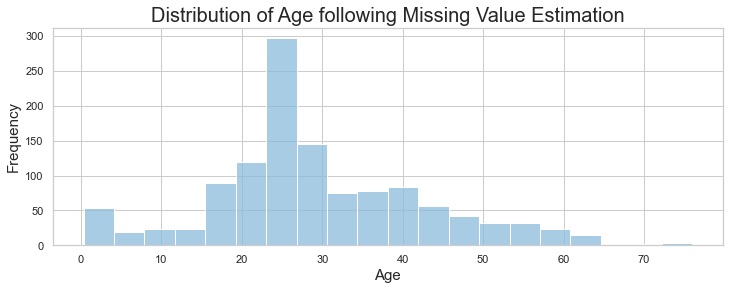

In [21]:
# Set the style for seaborn and choose a color palette
sns.set(style="whitegrid")
blue_palette = sns.color_palette("Blues_d")
sns.set_palette(blue_palette)

# Plotting the distribution of the 'Age' column
plt.figure(figsize=(12, 4))
sns.histplot(balanced_train['Age'], bins=20, kde=False)
plt.title('Distribution of Age following Missing Value Estimation', fontsize=20)
plt.xlabel('Age', fontsize=15)
plt.ylabel('Frequency', fontsize=15)

# Save the plot
plt.show()


The handling of the missing values for Age maintains the distribution without skewing it left or right. However, it does appear to skew it towards the median age which could imapact the fit of the model. 

In [22]:
# Balanced Data Set: Executing feature engineering again following additon of Ages. 
# Is alone
balanced_train.loc[((balanced_train['SibSp'] + balanced_train['Parch']) > 0), "n_is_alone"] = "No"
balanced_train.loc[((balanced_train['SibSp'] + balanced_train['Parch']) == 0), "n_is_alone"] = "Yes"

# Age level
balanced_train.loc[(balanced_train['Age'] < 18), 'n_age_cat'] = 'Young'
balanced_train.loc[(balanced_train['Age'] >= 18) & (balanced_train['Age'] < 56), 'n_age_cat'] = 'Mature'
balanced_train.loc[(balanced_train['Age'] >= 56), 'n_age_cat'] = 'Senior'

# Sex according to age
balanced_train.loc[(balanced_train['Sex'] == 'male') & (balanced_train['Age'] <= 21), 'n_sex_cat'] = 'Young Male'
balanced_train.loc[(balanced_train['Sex'] == 'male') & (balanced_train['Age'] > 21) & (balanced_train['Age'] < 50), 'n_sex_cat'] = 'Mature Male'
balanced_train.loc[(balanced_train['Sex'] == 'male') & (balanced_train['Age'] >= 50), 'n_sex_cat'] = 'Senior Male'
balanced_train.loc[(balanced_train['Sex'] == 'female') & (balanced_train['Age'] <= 21), 'n_sex_cat'] = 'Young Female'
balanced_train.loc[(balanced_train['Sex'] == 'female') & (balanced_train['Age'] > 21) & (balanced_train['Age'] < 50), 'n_sex_cat'] = 'Mature Female'
balanced_train.loc[(balanced_train['Sex'] == 'female') & (balanced_train['Age'] >= 50), 'n_sex_cat'] = 'Senior Female'

# Check for missing values
balanced_train.isna().sum()


Survived         0
Pclass           0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             0
Embarked         0
n_title          0
n_family_size    0
n_is_alone       0
n_age_cat        0
n_sex_cat        0
dtype: int64

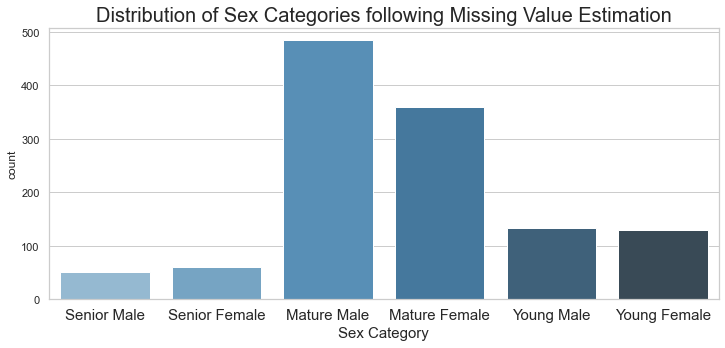

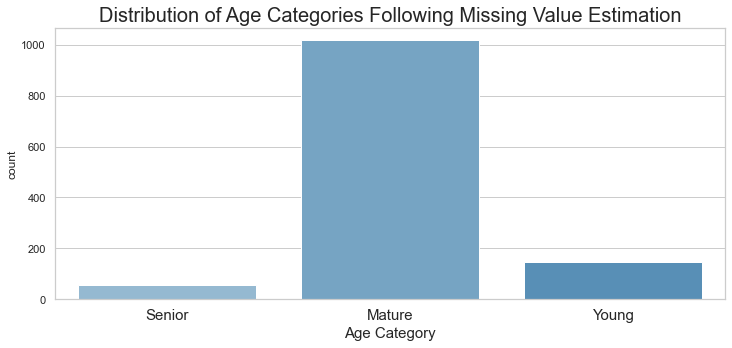

In [23]:
# Distribution of sex categories
age_order = ['Senior Male', 'Senior Female', 'Mature Male', 'Mature Female', 'Young Male', 'Young Female']
plt.figure(figsize=(12, 5))
sns.countplot(x='n_sex_cat', data=balanced_train, order=age_order, palette=blue_palette)
plt.title('Distribution of Sex Categories following Missing Value Estimation', fontsize=20)
plt.xlabel('Sex Category', fontsize=15)
plt.xticks(fontsize=15)
plt.show()

# Distribution of age categories
age_order = ['Senior', 'Mature', 'Young']
plt.figure(figsize=(12, 5))
sns.countplot(x='n_age_cat', data=balanced_train, order=age_order, palette=blue_palette)
plt.title('Distribution of Age Categories Following Missing Value Estimation', fontsize=20)
plt.xlabel('Age Category', fontsize=15)
plt.xticks(fontsize=15)
plt.show()


### One-Hot Encoding

Because models cannot handle variables with multiple classes very well, I opted to use the One-Hot Encoding technique. For this I assigned a binary value to each class via its own column. This would prevent the model from mistakenly weighting a class as being more important then the other because it had a higher value.  

In [24]:
cat_cols = ["Pclass", "Sex", "SibSp", "Parch", "Embarked", "n_title", "n_is_alone", "n_age_cat", "n_sex_cat"]
num_cols = ["Age", "Fare", "n_family_size"]
target_label = 'Survived'

# Find binary variables
binary_cols = [col for col in balanced_train.columns if col in cat_cols and balanced_train[col].nunique() == 2]
print(f'Categorical variables with binary classes: {binary_cols}')

# Find categorical variables with more than two classes
one_hot_cols = [col for col in cat_cols if balanced_train[col].nunique() > 2]
print(f"Categorical variables with multiple classes: {one_hot_cols}")

# Apply one-hot encoding
balanced_train = pd.get_dummies(balanced_train, columns= binary_cols + one_hot_cols)

Categorical variables with binary classes: ['Sex', 'n_is_alone']
Categorical variables with multiple classes: ['Pclass', 'SibSp', 'Parch', 'Embarked', 'n_title', 'n_age_cat', 'n_sex_cat']


## Prepare Test Data

Once I was comfortable with my EDA, I prepared my test data the exact same way the train data was set up. This is done separately after splitting to avoid Data Leakage. 

In [25]:
# Remove 'Cabin' column
test = test.drop('Cabin', axis=1)

# Remove 'Ticket', 'PassengerId', and 'Name' columns
columns_to_drop = ['Ticket', 'PassengerId']
test = test.drop(columns=columns_to_drop)

# Calculate the median age for each passenger class
median_age_by_class_test = test.groupby('Pclass')['Age'].median()

# Fill missing values in 'Age' column based on passenger class
test['Age'] = test.apply(
    lambda row: median_age_by_class_test[row['Pclass']] if pd.isnull(row['Age']) else row['Age'],
    axis=1
)

test = test.dropna(subset=['Fare'])

# 'Title' in name
test['n_title'] = test["Name"].str.extract(' ([A-Za-z]+)\.', expand=False)

test = test.drop('Name', axis=1)

# Family size
test["n_family_size"] = test["SibSp"] + test["Parch"] + 1

# Is alone
test.loc[((test['SibSp'] + test['Parch']) > 0), "n_is_alone"] = "No"
test.loc[((test['SibSp'] + test['Parch']) == 0), "n_is_alone"] = "Yes"

# Age level
test.loc[(test['Age'] < 18), 'n_age_cat'] = 'Young'
test.loc[(test['Age'] >= 18) & (test['Age'] < 56), 'n_age_cat'] = 'Mature'
test.loc[(test['Age'] >= 56), 'n_age_cat'] = 'Senior'

# Sex according to age
test.loc[(test['Sex'] == 'male') & (test['Age'] <= 21), 'n_sex_cat'] = 'Young male'
test.loc[(test['Sex'] == 'male') & (test['Age'] > 21) & (test['Age'] < 50), 'n_sex_cat'] = 'Mature male'
test.loc[(test['Sex'] == 'male') & (test['Age'] >= 50), 'n_sex_cat'] = 'Senior male'
test.loc[(test['Sex'] == 'female') & (test['Age'] <= 21), 'n_sex_cat'] = 'Young female'
test.loc[(test['Sex'] == 'female') & (test['Age'] > 21) & (test['Age'] < 50), 'n_sex_cat'] = 'Mature female'
test.loc[(test['Sex'] == 'female') & (test['Age'] >= 50), 'n_sex_cat'] = 'Senior female'

# Identify categorical columns
cat_cols_test = ["Pclass", "Sex", "SibSp", "Parch", "Embarked", "n_title", "n_is_alone", "n_age_cat", "n_sex_cat"]
num_cols_test = ["Age", "Fare", "n_family_size"]

# Find binary variables
binary_cols_test = [col for col in test.columns if col in cat_cols_test and test[col].nunique() == 2]
print(f'Categorical variables with binary classes: {binary_cols_test}')

# Find categorical variables with more than two classes
one_hot_cols_test = [col for col in cat_cols_test if test[col].nunique() > 2]
print(f"Categorical variables with multiple classes: {one_hot_cols_test}")

# Apply one-hot encoding
test = pd.get_dummies(test, columns=binary_cols_test + one_hot_cols_test)


Categorical variables with binary classes: ['Sex', 'n_is_alone']
Categorical variables with multiple classes: ['Pclass', 'SibSp', 'Parch', 'Embarked', 'n_title', 'n_age_cat', 'n_sex_cat']


### Handling mismatching shape sizes

Because of the encoding, some variables created in train are not present in test and vise versa. This is primarily due to some categories that have lower count are only present in one data set vs the other. As a result, the shapes of the data frames are not the same. To handle this, I identify the differences between the two and create a column of all zeros for any columns not present. For example, n_title_Rev was not present in Test, I created a column called n_title_Rev and assigned all 0s. 

In [26]:
missing_columns_in_test = set(train.columns) - set(test.columns)
missing_columns_in_train = set(test.columns) - set(train.columns)
# Add missing columns to 'test' with zeros
for col in missing_columns_in_test:
    test[col] = 0
    
# Add missing columns to 'train' with zeros
for col in missing_columns_in_train:
    train[col] = 0

In [27]:
missing_columns_in_test = set(balanced_train.columns) - set(test.columns)
missing_columns_in_train = set(test.columns) - set(balanced_train.columns)

print(missing_columns_in_test)
print(missing_columns_in_train)
# Add missing columns to 'test' with zeros
for col in missing_columns_in_test:
    test[col] = 0
    
# Add missing columns to 'train' with zeros
for col in missing_columns_in_train:
    balanced_train[col] = 0

{'n_title_Lady', 'n_sex_cat_Young Female', 'Parch_6', 'n_title_Major', 'n_title_Dr', 'Parch_9', 'n_title_Dona', 'n_sex_cat_Mature Female', 'n_sex_cat_Mature Male', 'n_title_Don', 'n_title_Ms', 'n_sex_cat_Young Male', 'n_title_Jonkheer', 'n_title_Mlle', 'n_sex_cat_Senior Female', 'n_sex_cat_Senior Male'}
{'Name', 'n_title_Capt', 'n_sex_cat_Senior female', 'Cabin', 'n_sex_cat_Young female', 'Pclass', 'n_sex_cat_Mature male', 'n_title_Sir', 'Embarked', 'Parch', 'Ticket', 'n_sex_cat', 'n_sex_cat_Mature female', 'Sex', 'PassengerId', 'n_title', 'n_age_cat', 'n_sex_cat_Senior male', 'SibSp', 'n_is_alone', 'n_sex_cat_Young male'}


In [28]:
# Print the size of the 'train' DataFrame
print("Train DataFrame Size:", train.shape)



# Print the size of the 'test' DataFrame
print("Test DataFrame Size:", test.shape)



Train DataFrame Size: (981, 57)
Test DataFrame Size: (327, 73)


# Modeling

For my modeling, I chose to fit three different models to assess which would work best. I fit a Random Forest, AdaBoost and SVM model. The results are below. I used the parameter tuining method described in lecture and applied in previous assignments to assess which parameters would work best for the models I was fitting. 

In [29]:
# Create X and Y data frames for balanced Train
X_btrain = balanced_train.drop(['Survived'], axis=1)
y_btrain = balanced_train['Survived']
x_test = test.drop(['Survived'], axis = 1)
y_test = test['Survived']

### Parameter Tuining - Random Forest

In [30]:
# Create a RandomForestClassifier
random_forest_model = RandomForestClassifier(random_state=95)

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': np.linspace(50, 200, 3, dtype=int),
    'max_depth': np.linspace(1, 20, 3, dtype = int),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
# Use GridSearchCV to perform grid search
grid_search = GridSearchCV(random_forest_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_btrain, y_btrain)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=95),
             param_grid={'max_depth': array([ 1, 10, 20]),
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': array([ 50, 125, 200])},
             scoring='accuracy')

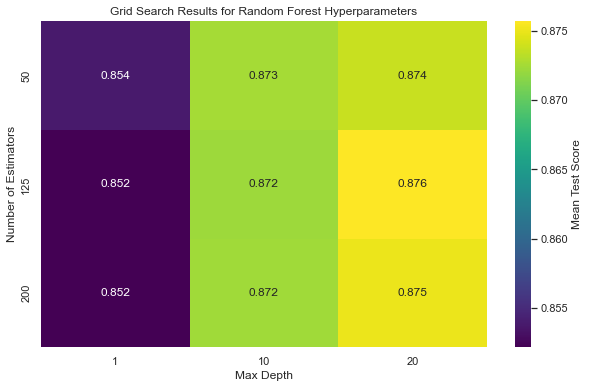

Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 125}


In [31]:
# Extract results from the grid search
results = pd.DataFrame(grid_search.cv_results_)

# Pivot the DataFrame for easy plotting
heatmap_data = results.pivot_table(index='param_n_estimators', columns='param_max_depth',
                                   values='mean_test_score', aggfunc='mean')

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="viridis", cbar_kws={'label': 'Mean Test Score'})
plt.title("Grid Search Results for Random Forest Hyperparameters")
plt.xlabel("Max Depth")
plt.ylabel("Number of Estimators")

# Save the plot
plt.show()

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)

In [32]:
random_forest_model = RandomForestClassifier(random_state=95)

# Fit model using best parameters from Gridsearch
random_forest_model = RandomForestClassifier(n_estimators = 200, max_depth = 20, min_samples_leaf = 1, min_samples_split = 2, random_state=95)
random_forest_model.fit(X_btrain, y_btrain)

# Make predictions on the test data
y_pred_rf = random_forest_model.predict(x_test)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
classification_rep_rf = classification_report(y_test, y_pred_rf)

print(f"Random Forest Accuracy: {accuracy_rf}")
print("\nRandom Forest Boost Classification Report:")
print(classification_rep_rf)

Random Forest Accuracy: 0.8532110091743119

Random Forest Boost Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.90      0.88       203
           1       0.83      0.77      0.80       124

    accuracy                           0.85       327
   macro avg       0.85      0.84      0.84       327
weighted avg       0.85      0.85      0.85       327



#### Accuracy:
The model achieved an accuracy of approximately 85%. This means that the model correctly predicted the survival outcome for 85% of the instances in the test set. A high accuracy suggests that the model is effective in capturing the underlying patterns in the data.

#### Precision, Recall, and F1-Score:
The precision, recall, and F1-score values provide a more detailed view of the model's performance, particularly when dealing with imbalanced classes.

Precision: The precision for survival (class 1) and non-survival (class 0) indicates the proportion of correctly predicted instances among those predicted as survivors or non-survivors. High precision suggests low false positives.

Recall: Recall, also known as sensitivity or true positive rate, measures the proportion of actual survivors and non-survivors correctly predicted by the model. High recall indicates low false negatives.

F1-Score: The F1-score is the harmonic mean of precision and recall, providing a balance between the two metrics. 

#### Class-specific Performance:
For survival (class 1), the precision is 0.83, recall is 0.77, and F1-score is 0.79.
For non-survival (class 0), the precision is 0.86, recall is 0.90, and F1-score is 0.88. These metrics support that the model is fitting the data well. 

#### Model Generalization:
The similarity in performance between the training and test sets indicates good generalization. This suggests that the model is not overfitting the training data and can effectively make predictions on new, unseen data.

###  Parameter Tuining - AdaBoost

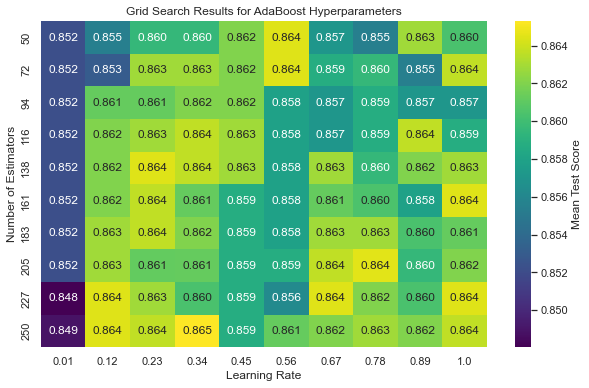

Best Parameters: {'n_estimators': 250, 'learning_rate': 0.34}


In [33]:
# Create an AdaBoostClassifier
adaboost_model = AdaBoostClassifier(random_state=95)

# Define the hyperparameter grid to search
# Number of values within the range
num_values = 10

# Updated param_grid with more values using np.linspace
param_grid = {
    'n_estimators': np.linspace(50, 250, num=num_values, dtype=int),
    'learning_rate': np.linspace(0.01, 1, num=num_values),
}

# Use GridSearchCV to perform grid search
grid_search = GridSearchCV(adaboost_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_btrain, y_btrain)

# Extract results from the grid search
results = pd.DataFrame(grid_search.cv_results_)

# Pivot the DataFrame for easy plotting
heatmap_data = results.pivot(index='param_n_estimators', columns='param_learning_rate', values='mean_test_score')

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="viridis", cbar_kws={'label': 'Mean Test Score'})
plt.title("Grid Search Results for AdaBoost Hyperparameters")
plt.xlabel("Learning Rate")
plt.ylabel("Number of Estimators")
plt.show()

# Print the best parameters
best_index = results['mean_test_score'].idxmax()
best_params = {
    'n_estimators': results.loc[best_index, 'param_n_estimators'],
    'learning_rate': results.loc[best_index, 'param_learning_rate']
}
print("Best Parameters:", best_params)

In [34]:
# Fit model using best parameters from Gridsearch
ada_model = AdaBoostClassifier(n_estimators = 250, learning_rate = 0.34, random_state=95)
ada_model.fit(X_btrain, y_btrain)

# Make predictions on the test data
y_pred_ada = ada_model.predict(x_test)

# Evaluate the model
accuracy_ada = accuracy_score(y_test, y_pred_ada)
classification_rep_ada = classification_report(y_test, y_pred_ada)

print(f"Ada Boost Accuracy: {accuracy_ada}")
print("\nAda Boost Classification Report:")
print(classification_rep_ada)


Ada Boost Accuracy: 0.6422018348623854

Ada Boost Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.91      0.76       203
           1       0.58      0.20      0.30       124

    accuracy                           0.64       327
   macro avg       0.62      0.56      0.53       327
weighted avg       0.62      0.64      0.59       327



#### Accuracy:
The Ada Boost model achieved an accuracy of approximately 64%, indicating that it correctly predicted the survival outcome for 64% of instances in the test set.

#### Precision, Recall, and F1-Score:
These metrics provide a more detailed understanding of the model's effectiveness.

Precision: For survival (class 1), the precision is 0.58, and for non-survival (class 0), the precision is 0.65. These values represent the proportion of correctly predicted instances among those predicted as survivors or non-survivors.

Recall: The recall for survival is 0.20, and for non-survival, it is 0.91. These values indicate the proportion of actual survivors or non-survivors correctly predicted by the model.

F1-Score: The F1-score for survival is 0.30, and for non-survival, it is 0.76. The F1-score provides a balance between precision and recall.

#### Class-specific Performance:
For survival (class 1), the model shows a lower recall, indicating a higher number of false negatives.

For non-survival (class 0), the model exhibits high precision and recall, suggesting good accuracy in predicting non-survivors.

The F1 scores suggest the model might not be robust in all predictions.

#### Model Generalization:
The similarity in performance between the training and test sets suggests that the Ada Boost model generalizes well to new, unseen data but could lack robustness. This is crucial for the model's practical applicability beyond the training dataset.

###  Parameter Tuining - Support Vector Machine

For SVM, the features are standardized due to the algorithims sensitivity to scale. 

In [35]:
# Standardize the features using StandardScaler
scaler = StandardScaler()
X_btrain_scaled = scaler.fit_transform(X_btrain)
X_test_scaled = scaler.transform(x_test)

# Create an SVM classifier
svm_model = SVC(random_state=42)

# Specify the range for C and gamma using a logarithmic scale
param_grid = {
    'C': 2.0 ** np.arange(-5, 6),
    'gamma': 2.0 ** np.arange(-5, 6)
}

# Create a GridSearchCV object
grid = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=3, scoring='accuracy')

# Fit the grid search to the data
grid.fit(X_btrain_scaled, y_btrain)


GridSearchCV(cv=3, estimator=SVC(random_state=42),
             param_grid={'C': array([3.125e-02, 6.250e-02, 1.250e-01, 2.500e-01, 5.000e-01, 1.000e+00,
       2.000e+00, 4.000e+00, 8.000e+00, 1.600e+01, 3.200e+01]),
                         'gamma': array([3.125e-02, 6.250e-02, 1.250e-01, 2.500e-01, 5.000e-01, 1.000e+00,
       2.000e+00, 4.000e+00, 8.000e+00, 1.600e+01, 3.200e+01])},
             scoring='accuracy')

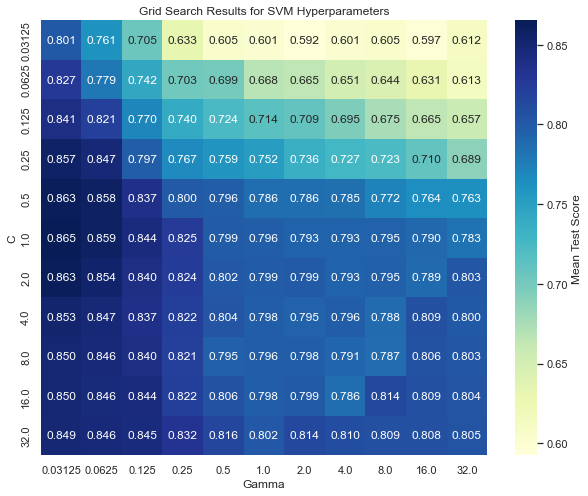

Best Parameters: {'C': 1.0, 'gamma': 0.03125}


In [36]:
# Extract results from the grid search
results = pd.DataFrame(grid.cv_results_)

# Pivot the DataFrame for a 2D heatmap
heatmap_data = results.pivot(index='param_C', columns='param_gamma', values='mean_test_score')

# Plot the 2D heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlGnBu", cbar_kws={'label': 'Mean Test Score'})
plt.title('Grid Search Results for SVM Hyperparameters')
plt.xlabel('Gamma')
plt.ylabel('C')

# Save the plot
plt.show()

# Print the best parameters
best_index = results['mean_test_score'].idxmax()
best_params = {
    'C': results.loc[best_index, 'param_C'],
    'gamma': results.loc[best_index, 'param_gamma']
}
print("Best Parameters:", best_params)


In [37]:
# Fit model using best parameters from Gridsearch
SVM_model = SVC(C=1, gamma=0.03125, random_state=42)
SVM_model.fit(X_btrain_scaled, y_btrain)

# Make predictions on the test data
y_pred_SVM = SVM_model.predict(X_test_scaled)

# Evaluate the model
accuracy_SVM = accuracy_score(y_test, y_pred_SVM)
classification_rep_SVM = classification_report(y_test, y_pred_SVM)

print(f"SVM Accuracy: {accuracy_SVM}")
print("\nSVM Classification Report:")
print(classification_rep_SVM)


SVM Accuracy: 0.5963302752293578

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.96      0.75       203
           1       0.00      0.00      0.00       124

    accuracy                           0.60       327
   macro avg       0.31      0.48      0.37       327
weighted avg       0.38      0.60      0.46       327



The SVM model shows an accuracy of approximately 60%, suggesting a moderate level of predictive performance. However, a deeper analysis of the precision, recall, and F1-score reveals some insights into the model's strengths and weaknesses.

#### Precision:

For class 0 (non-survival), the precision is 0.61. This indicates that among the instances predicted as non-survivors, 61% were correctly classified.
For class 1 (survival), the precision is 0, suggesting that the model has no ability to predict survival.

#### Recall:

For class 0, the recall is 0.
For class 1, the recall is 0.96, indicating a very high proportion of actual survivors correctly identified by the model.

#### F1-Score:

The F1-score for class 0 is 0.75, representing a balance between precision and recall for non-survivors.
The F1-score for class 1 is 0 which makes sense given the 0 in precision and recall. 

#### Macro Avg and Weighted Avg:

The macro average of precision, recall, and F1-score considers equal weight to both classes, yielding an average that reflects overall model performance.
The weighted average provides a similar average but considers the number of true instances for each class, providing a more balanced view when classes have imbalanced sizes.

#### Model Assessment:

The SVM model's performance is characterized by a high precision for predicting non-survival and a high recall for the same class. This indicates that while the model is accurate when predicting survivors, it misses a substantial number of actual survivors. The overall accuracy is influenced by the dominant class (non-survivors), leading to a decent accuracy score despite the model's limitations in predicting survivors.

#### Considerations:

SVM is not an appropriate model to be used here. Despite balancing the classes the model still fails to predict survival and has a low accuracy compared to the other models. This could be contributed to the data not having a clear division which SVM heavily depends on to be accuract. 

## Results and Analysis

While both outperform SVM, the Random Forest model outperforms the Ada Boost model in terms of accuracy and several other metrics:

- Accuracy: Random Forest has a higher accuracy (85.32% vs. 64.22%).
- Precision (Class 0): Random Forest has higher precision for Class 0 (86% vs. 64%).
- Recall (Class 0): Random Forest has slightly lower recall for Class 0 but it is still high (90% vs. 91%).
- F1-score (Class 0): Random Forest has a higher F1-score for Class 0 (88% vs. 76%).
- Precision (Class 1): Random Forest has higher precision for Class 1 (83% vs. 58%).
- Recall (Class 1): Random Forest has higher recall for Class 1 (77% vs. 20%).
- F1-score (Class 1): Random Forest has a higher F1-score for Class 1 (80% vs. 30%).

It is possible that AdaBoost performs worse because the model has failed to prioritize the features effectively or due to its sensitivity to noisy data. While this data might not be particularly noisy, there are cases of outliers that are relevant to the dataset but could still be negatively impacting the effectiveness of the model. 

In summary, the Random Forest model demonstrates better overall performance, achieving higher accuracy and competitive precision, recall, and F1-scores for both classes.

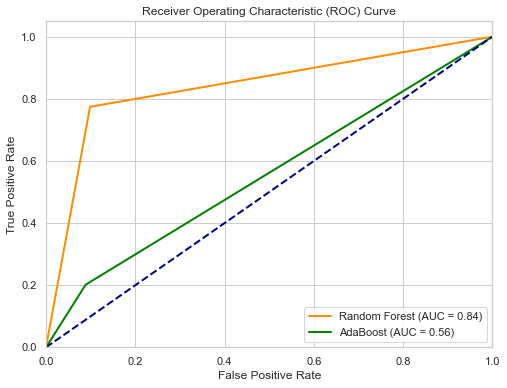

In [38]:
# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# AdaBoost
fpr_ada, tpr_ada, _ = roc_curve(y_test, y_pred_ada)
roc_auc_ada = auc(fpr_ada, tpr_ada)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_ada, tpr_ada, color='green', lw=2, label=f'AdaBoost (AUC = {roc_auc_ada:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

The ROC Curve above supports the finding that Random Forest is a better model for the data set. 

### Using Cross-Validation as a Final Measure of Performance

Finally, I would like to use cross validation to see if there could be any subset of data that would lead to significantly better performance. 

In [39]:
# Perform 5-fold cross-validation (you can adjust the cv parameter)
cross_val_scores = cross_val_score(random_forest_model, X_btrain, y_btrain, cv=10, scoring='accuracy')

# Print the cross-validation scores
print("Cross-Validation Scores:", cross_val_scores)

# Calculate and print the mean accuracy
mean_accuracy = cross_val_scores.mean()
print("Mean Accuracy:", mean_accuracy)


Cross-Validation Scores: [0.93442623 0.82786885 0.86885246 0.90163934 0.89344262 0.90983607
 0.92622951 0.89256198 0.90909091 0.91735537]
Mean Accuracy: 0.8981303346430023


The cross validation scores indicate a relatively consistent performance across multiple folds. This suggests the Random Forest is not heavily influenced by any one subset of data. Additionally, this consistency lends itself to robustness as the model has an ability to generalize itself well to the data. 

## Conclusion

Like the Titanic, this is not a perfect machine. 

The process of arriving at the final model, the Random Forest Classification, involved a combination of domain knowledge, intuition, and data-driven analysis. While the model achieved an accuracy of 85%, it's important to acknowledge the potential for overfitting when performing extensive feature engineering. The decision-making process aimed to avoid data leakage and minimize bias, but subject matter expertise could provide valuable insights for further model refinement.

One notable aspect is the handling of missing values for the 'Age' variable. The approach used, relying on class-specific median ages, might introduce biases and skew the distribution, particularly in scenarios where wealthy families with young children are not adequately represented. Reevaluation of this aspect could be a priority in future work.

The Random Forest model, tailored to the dataset, demonstrates its effectiveness in predicting survival on the Titanic. However, it's crucial to recognize the limitations inherent in modeling an event from over a century ago. The applicability of the model to modern scenarios, such as predicting outcomes in modern cruise settings with advanced safety practices, remains uncertain.

In conclusion, the Random Forest model successfully addresses the specific task of predicting survival on the Titanic using supervised learning. The achieved accuracy of 85% is considered acceptable for this historical dataset. Further refinements and insights from domain experts could enhance the model's performance and interpretability, with a primary focus around feature engineering that could leverage this expertise to gain further insight into the raw data. 